This notebook counts transcripts at branches of foreskin sample, in particular melanocytes. Bulk.

In [5]:
from tifffile import imread
import os
import numpy as np
import pandas as pd
from skimage.filters import gaussian
import napari
from starmap.sequencing import *
from scipy import ndimage
from skimage.morphology import binary_dilation, square

In [2]:
ppath = 'Z:/Data/Processed/2022-10-15-Rena-SkinCulture254-gene'
impath = os.path.join(ppath, 'output', '2022-10-30-stitching/flamingo')
ptpath = os.path.join(ppath, 'output', '2022-11-07-merged-points')
area_list = range(1,7)

In [3]:
def load_reads(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 2]-1) 
    temp[:, 1] = np.round(points[:, 1]-1)
    temp[:, 2] = np.round(points[:, 0]-1)
    
    print(f"Number of reads: {len(bases)}")
    
    return bases, temp

def load_genes(fpath):
    genes2seq = {}
    seq2genes = {}
    with open(os.path.join(fpath, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            genes2seq[fields[0]] = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            seq2genes[genes2seq[fields[0]]] = fields[0]
    return genes2seq, seq2genes

In [4]:
genes2seqs, seqs2genes = load_genes(ppath)
genes = genes2seqs.keys()
genes_to_index = {}  
for i, k in enumerate(genes):
    genes_to_index[k] = i

In [9]:
for area in area_list:
    # binary
    im = imread(os.path.join(impath, f'Area{area}_ec.tif'))
    imbn = np.zeros(im.shape)
    for z in range(im.shape[0]):
        temp = gaussian(im[z])
        temp = temp > 0.05
        temp = binary_dilation(temp, square(7))
        imbn[z] = ndimage.binary_fill_holes(temp)
    # points
    bases, points = load_reads(os.path.join(ppath, 'output', '2022-11-07-merged-points', f'Area{area}'), "merged_goodPoints.mat")
    bases = np.array([seqs2genes[x] for x in bases])
    points = np.array(points)
    points = points.astype(int)
    # count
    count_in = [0]*len(genes)
    count_out = [0]*len(genes)
    for i, pt in enumerate(points):
        idx = list(genes).index(bases[i])
        if imbn[pt[0], pt[1], pt[2]]:
            count_in[idx] +=1
        else: count_out[idx] +=1
    df = pd.DataFrame(zip(list(genes), count_in, count_out), columns=['gene', 'count_in', 'count_out'])
    df.to_csv(os.path.join(ppath, 'output', 'reads_assigned', f'counts_Area{area}.csv'))

Number of reads: 893831
Number of reads: 990123
Number of reads: 628307
Number of reads: 1404691
Number of reads: 480138
Number of reads: 2299965


In [9]:
# test
# im_test = im[:, 5000:8000, 5000:8000]
# imbn = np.zeros(im_test.shape)
# for z in range(im_test.shape[0]):
#     temp = gaussian(im_test[z])
#     temp = temp > 0.05
#     temp = binary_dilation(temp, square(7))
#     imbn[z] = ndimage.binary_fill_holes(temp)
#     # break
# viewer = napari.view_image(imbn)

<AxesSubplot:ylabel='Count'>

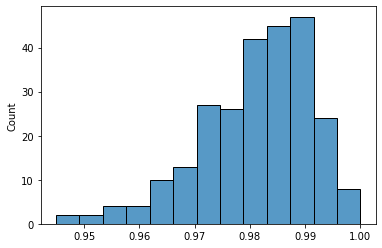

In [22]:
import seaborn as sns
sns.histplot(pct)